In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
u_df= pd.read_json('ultimate_data_challenge.json')
df=pd.read_json('logins.json')

In [14]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


# Data description
1. city: city this user signed up in
2. phone: primary device for this user
3. signup_date: date of account registration; in the form ‘YYYY MM DD’
4. last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
5. avg_dist: the average distance in miles per trip taken in the first 30 days after signup
6. avg_rating_by_driver: the rider’s average rating over all of their trips
7. avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
8. surge_pct: the percent of trips taken with surge multiplier > 1
9. avg_surge: The average surge multiplier over all of this user’s trips
10. trips_in_first_30_days: the number of trips this user took in the first 30 days aftersigning up
11. Ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;FALSE otherwise
12. weekday_pct: the percent of the user’s trips occurring during a weekday

# Part 1 ‑Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­ minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.

# Data Cleaning

In [15]:
df.shape

(93142, 1)

In [16]:
df.isnull().sum()

login_time    0
dtype: int64

In [17]:
df.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [20]:
df['login_count'] = 1
# convert the date to a datetime object, and set it as the index
login_data = df.set_index(pd.to_datetime(df['login_time'], unit='s'))[['login_count']]
# make sure everything worked
login_data.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [21]:
logins_delta15 = login_data.resample('15Min').sum()

In [23]:
logins_delta15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


# Visualize processed data

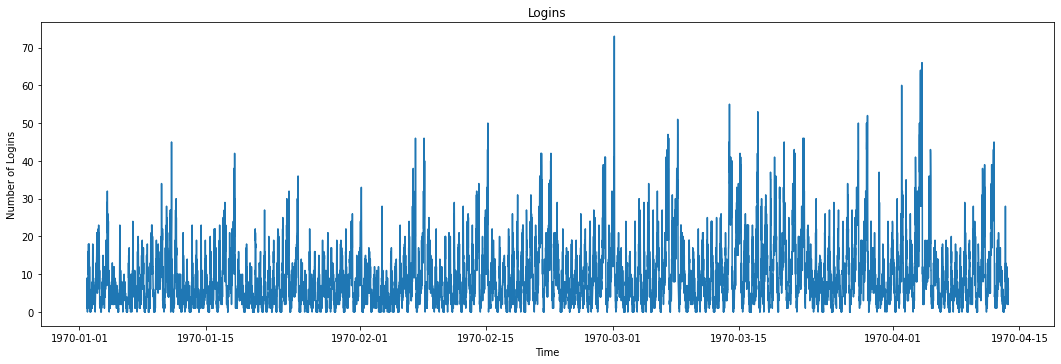

In [22]:
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.tight_layout()
plt.title('Logins')
# puts the data in the figure
plt.plot(logins_delta15.index, logins_delta15.login_count)

# bin data by the day
1. Day
2. Weekdays
3. Friday 
4. Saturday
5. Sunday

In [24]:
logins_daily = login_data.resample('D').sum()
logins_biz_day = login_data.resample('B').sum()
fridays = login_data.resample('W-FRI').sum()
saturdays = login_data.resample('W-SAT').sum()
sundays = login_data.resample('W-SUN').sum()

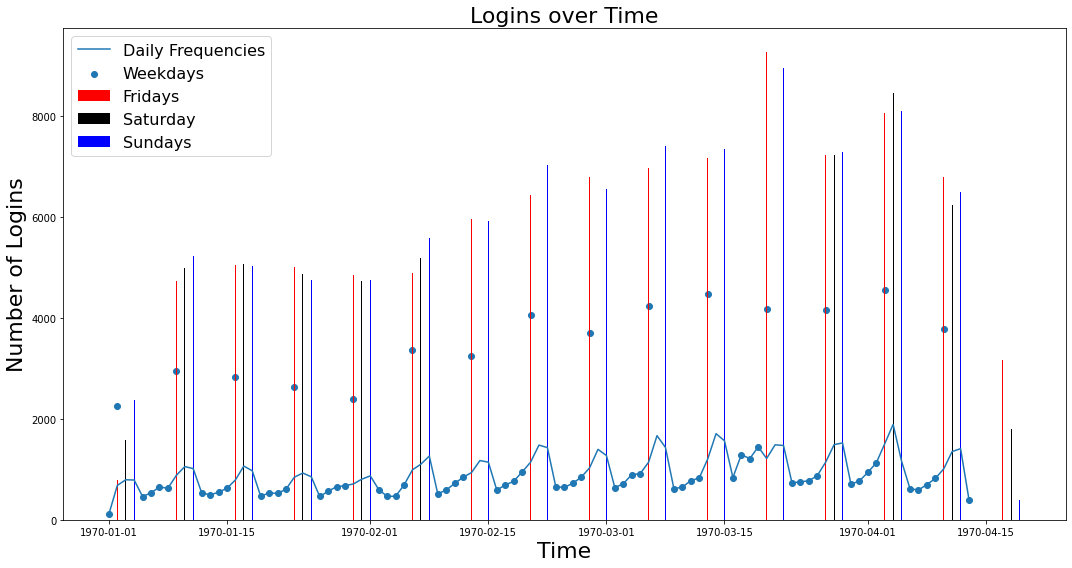

In [26]:
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Number of Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.bar(fridays.index, fridays.login_count, align= 'center', width = 0.1, label = "Fridays", color = 'Red')
plt.bar(saturdays.index, saturdays.login_count, label = 'Saturday', align = 'center', width = 0.1, color = 'Black')
plt.bar(sundays.index, sundays.login_count, label = "Sundays", align= 'center', width = 0.1, color = 'Blue')
plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(logins_biz_day.index, logins_biz_day.login_count, label='Weekdays')

plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

# Find hourly trends by day of week

In [27]:
daily_logins = login_data.resample('H').sum()

In [28]:
day_of_week = list(daily_logins.index.dayofweek)

daily_logins['day_of_week'] = day_of_week

In [39]:
daily_logins.head()

,login_count,day_of_week,hour
login_time,,,
1970-01-01 20:00:00,24,3,20
1970-01-01 21:00:00,9,3,21
1970-01-01 22:00:00,21,3,22
1970-01-01 23:00:00,58,3,23
1970-01-02 00:00:00,53,4,0


In [30]:
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [38]:
avg_hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour',
                                   columns = 'day_of_week',
                                   aggfunc=np.mean).rename(columns= {0:'Monday',1:'Tuesday',2:'Wednesday',
                                                                     3:'Thursday',4:'Friday',5:'Saturday',
                                                                     6:'Sunday'})

In [40]:
avg_hourly_logins = avg_hourly_logins.stack(level=['day_of_week'])

In [42]:
avg_hourly_logins.name = 'avg_num_logins'
avg_hourly_logins_df = avg_hourly_logins.reset_index()

In [43]:
avg_hourly_logins_df.head()

,hour,day_of_week,avg_num_logins
0,0,Monday,35.400000
1,0,Tuesday,43.357143
2,0,Wednesday,49.071429
3,0,Thursday,58.285714
4,0,Friday,65.000000


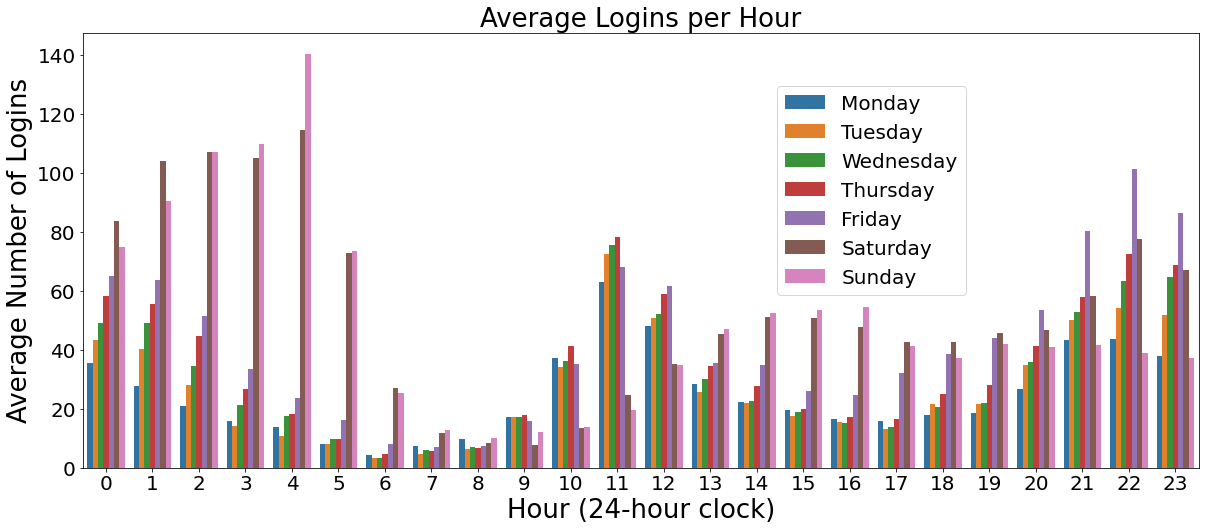

In [60]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(x='hour', y='avg_num_logins', data=avg_hourly_logins_df,
            hue='day_of_week')
ax = plt.gca()
ax.set_title('Average Logins per Hour', fontsize = 26)
ax.set_xlabel('Hour (24-hour clock)', fontsize = 26)
ax.set_ylabel('Average Number of Logins', fontsize = 26)
ax.tick_params(labelsize=20,labelcolor="black")
ax.legend(bbox_to_anchor=(0.7,0.7,0.1, 0.2),fontsize=20)